# Advanced Feature Engineering in Keras 

**Learning Objectives**

1. Use Lambda layers to perform feature engineering on geolocation features 
2. Create bucketized and crossed feature columns
 

## Overview 

In this notebook, we use Keras to build a taxifare price prediction model and utilize feature engineering to improve the fare amount prediction for NYC taxi cab rides. 

We will start by importing the necessary libraries for this lab.

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Discretization,
    Embedding,
    Flatten,
    Input,
    Lambda,
)
from tensorflow.keras.layers.experimental.preprocessing import HashedCrossing

# set TF error log verbosity
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(tf.version.VERSION)

2.8.0


## Load taxifare dataset

The Taxi Fare dataset for this lab is 106,545 rows and has been pre-processed and split for use in this lab.  The fare_amount is the target, the continuous value we’ll train a model to predict.  

Let's check that the files look like we expect them to.

In [2]:
!ls -l ../data/taxi-*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Jul 11 18:42 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Jul 11 18:42 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Jul 11 18:42 ../data/taxi-valid.csv


In [3]:
!head ../data/taxi-*.csv

==> ../data/taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> ../data/taxi-train.csv <==
11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
10.5,2011-04-03 0

## Create an input pipeline 

Typically, you will use a two step process to build the pipeline. Step one is to define the columns of data; i.e., which column we're predicting for, and the default values.  Step 2 is to define two functions - a function to define the features and label you want to use and a function to load the training data.  


In [4]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]

INPUT_COLS = [
    c for c in CSV_COLUMNS if c != LABEL_COLUMN and c not in UNWANTED_COLS
]

In [5]:
# A function to define features and labesl
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


# A utility method to create a tf.data dataset from a Pandas Dataframe
def load_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )
    dataset = dataset.map(features_and_labels)  # features, label
    if mode == "train":
        dataset = dataset.shuffle(1000).repeat()
        # take advantage of multi-threading; 1=AUTOTUNE
        dataset = dataset.prefetch(1)
    return dataset

## Create a Baseline DNN Model in Keras

Now let's build the Deep Neural Network (DNN) model in Keras using the functional API. Unlike the sequential API, we will need to specify the input and hidden layers.  Note that we are creating a linear regression baseline model with no feature engineering. Recall that a baseline model is a solution to a problem without applying any machine learning techniques.

In [6]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():
    # input layer
    inputs = {
        colname: Input(name=colname, shape=(1,), dtype="float32")
        for colname in INPUT_COLS
    }

    # Constructor for DenseFeatures takes a list of numeric columns
    concat_inputs = Concatenate()(inputs.values())

    # two hidden layers of [32, 8]
    h1 = Dense(32, activation="relu", name="h1")(concat_inputs)
    h2 = Dense(8, activation="relu", name="h2")(h1)

    # final output is a linear activation because this is regression
    output = Dense(1, activation="linear", name="fare")(h2)
    model = models.Model(inputs, output)

    # compile model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

We'll build our DNN model and inspect the model architecture.

2022-07-13 19:50:21.145759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-07-13 19:50:21.145838: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 19:50:21.145877: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hurb-asl): /proc/driver/nvidia/version does not exist
2022-07-13 19:50:21.146434: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


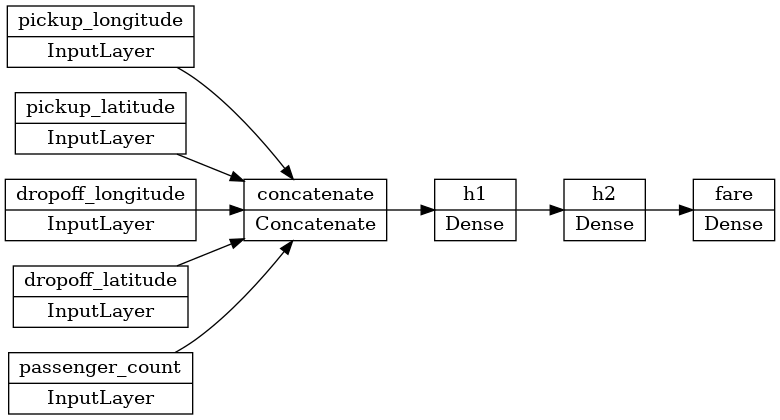

In [7]:
model = build_dnn_model()

tf.keras.utils.plot_model(
    model, "dnn_model.png", show_shapes=False, rankdir="LR"
)

## Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).  Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

We start by setting up the environment variables for training, creating the input pipeline datasets, and then train our baseline DNN model.

In [8]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 1000

In [9]:
trainds = load_dataset("../data/taxi-train*", TRAIN_BATCH_SIZE, "train")
evalds = load_dataset("../data/taxi-valid*", 1000, "eval").take(
    NUM_EVAL_EXAMPLES // 1000
)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/5
312/312 [==============================] - 2s 4ms/step - loss: 343.5836 - rmse: 17.1468 - mse: 343.5836 - val_loss: 263.0466 - val_rmse: 16.2187 - val_mse: 263.0466
Epoch 2/5
312/312 [==============================] - 1s 3ms/step - loss: 209.7291 - rmse: 14.0958 - mse: 209.7291 - val_loss: 252.7281 - val_rmse: 15.8974 - val_mse: 252.7281
Epoch 3/5
312/312 [==============================] - 1s 3ms/step - loss: 214.9084 - rmse: 14.2257 - mse: 214.9084 - val_loss: 238.5464 - val_rmse: 15.4449 - val_mse: 238.5464
Epoch 4/5
312/312 [==============================] - 1s 3ms/step - loss: 207.1463 - rmse: 14.0326 - mse: 207.1463 - val_loss: 224.2409 - val_rmse: 14.9747 - val_mse: 224.2409
Epoch 5/5
312/312 [==============================] - 1s 3ms/step - loss: 201.1167 - rmse: 13.7323 - mse: 201.1167 - val_loss: 226.2611 - val_rmse: 15.0420 - val_mse: 226.2611


### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

In [10]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        plt.plot(history.history[key])
        plt.plot(history.history[f"val_{key}"])
        plt.title(f"model {key}")
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");

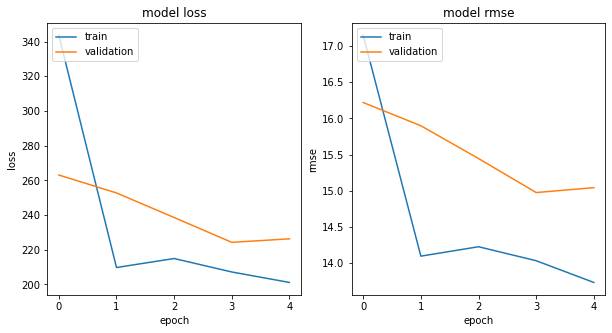

In [11]:
plot_curves(history, ["loss", "rmse"])

### Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.  

In [12]:
model.predict(
    {
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

array([[1.2847099]], dtype=float32)

## Improve Model Performance Using Feature Engineering 

We now improve our model's performance by creating new feature engineerings. 

### Geolocation/Coordinate Feature Columns

The pick-up/drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled. As such, we need to teach the model the Euclidean distance between the pick-up and drop-off points.

Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates. In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York city has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

#### Computing Euclidean distance
The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordinate points.

In [13]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff * londiff + latdiff * latdiff)

#### Scaling latitude and longitude

It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here we use min-max scaling (also called normalization) on the geolocation features.  Later in our model, you will see that these values are shifted and rescaled so that they end up ranging from 0 to 1.

First, we create a function named 'scale_longitude', where we pass in all the longitudinal values and add 78 to each value.  Note that our scaling longitude ranges from -70 to -78. Thus, the value 78 is the maximum longitudinal value.  The delta or difference between -70 and -78 is 8.  We add 78 to each longitudinal value and then divide by 8 to return a scaled value.

In [14]:
def scale_longitude(lon_column):
    return (lon_column + 78) / 8.0

Next, we create a function named 'scale_latitude', where we pass in all the latitudinal values and subtract 37 from each value.  Note that our scaling latitude ranges from -37 to -45. Thus, the value 37 is the minimal latitudinal value.  The delta or difference between -37 and -45 is 8.  We subtract 37 from each latitudinal value and then divide by 8 to return a scaled value.

In [15]:
def scale_latitude(lat_column):
    return (lat_column - 37) / 8.0

### Putting it all together

Next, we'll create our DNN model now with custom Lambda layers. We'll set `NBUCKETS = 10` to specify 10 buckets when bucketizing the latitude and longitude.

So here we define:
- 2 Lambda layers with scale_longitude function
- 2 Lambda layers with scale_latitude function
- a Lambda layers with euclidean function
- other feature engineering logics with predefined preprocessing layers
- DNN model architecture
- model compilation

**Exercise**.  Create `build_dnn_model` function by completing Lambda layers and preprocessing layers.

In [20]:
NBUCKETS = 10


# DNN MODEL
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():
    # input layer is all float
    inputs = {
        colname: Input(name=colname, shape=(1,), dtype="float32")
        for colname in INPUT_COLS
    }

    transformed = {}

    # Scaling longitude from range [-70, -78] to [0, 1]
    transformed["scaled_plon"] = Lambda(scale_longitude, name="scale_plon")(
        inputs["pickup_longitude"]
    )  # TODO
    transformed["scaled_dlon"] = Lambda(scale_longitude, name="scale_dlon")(
        inputs["dropoff_longitude"]
    )  # TODO

    # Scaling latitude from range [37, 45] to [0, 1]
    transformed["scaled_plat"] = Lambda(scale_latitude, name="scale_plat")(
        inputs["pickup_latitude"]
    )  # TODO
    transformed["scaled_dlat"] = Lambda(scale_latitude, name="scale_dlat")(
        inputs["dropoff_latitude"]
    )  # TODO

    # Apply euclidean function
    transformed["euclidean_distance"] = Lambda(euclidean, name="euclidean")(
        [
            inputs["pickup_longitude"],
            inputs["pickup_latitude"],
            inputs["dropoff_longitude"],
            inputs["dropoff_latitude"],
        ]
    )  # TODO

    latbuckets = np.linspace(start=0.0, stop=1.0, num=NBUCKETS).tolist()
    lonbuckets = np.linspace(start=0.0, stop=1.0, num=NBUCKETS).tolist()

    # Bucketization with Discretization layer
    plon = Discretization(lonbuckets, name="plon_bkt")(
        transformed["scaled_plon"]
    )  # TODO
    plat = Discretization(lonbuckets, name="plat_bkt")(
        transformed["scaled_plat"]
    )  # TODO
    dlon = Discretization(lonbuckets, name="dlon_bkt")(
        transformed["scaled_dlon"]
    )  # TODO
    dlat = Discretization(lonbuckets, name="dlat_bkt")(
        transformed["scaled_dlat"]
    )  # TODO

    # Feature Cross with HashedCrossing layer
    p_fc = HashedCrossing(num_bins=NBUCKETS**2, name="p_fc")(
        (plon, plat)
    )  # TODO
    d_fc = HashedCrossing(num_bins=NBUCKETS**2, name="d_fc")(
        (dlon, dlat)
    )  # TODO
    pd_fc = HashedCrossing(num_bins=NBUCKETS**4, name="pd_fc")(
        (p_fc, d_fc)
    )  # TODO

    # Embedding with Embedding layer
    transformed["pd_embed"] = Flatten()(
        Embedding(input_dim=NBUCKETS**4, output_dim=10, name="pd_embed")(
            pd_fc
        )  # TODO
    )

    transformed["passenger_count"] = inputs["passenger_count"]
    dnn_inputs = Concatenate()(transformed.values())

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = Dense(32, activation="relu", name="h1")(dnn_inputs)
    h2 = Dense(8, activation="relu", name="h2")(h1)

    # final output is a linear activation because this is regression
    output = Dense(1, activation="linear", name="fare")(h2)  # TODO
    model = models.Model(inputs, output)  # TODO

    # Compile model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse])  # TODO
    return model

In [21]:
model = build_dnn_model()

Let's see how our model architecture has changed now.

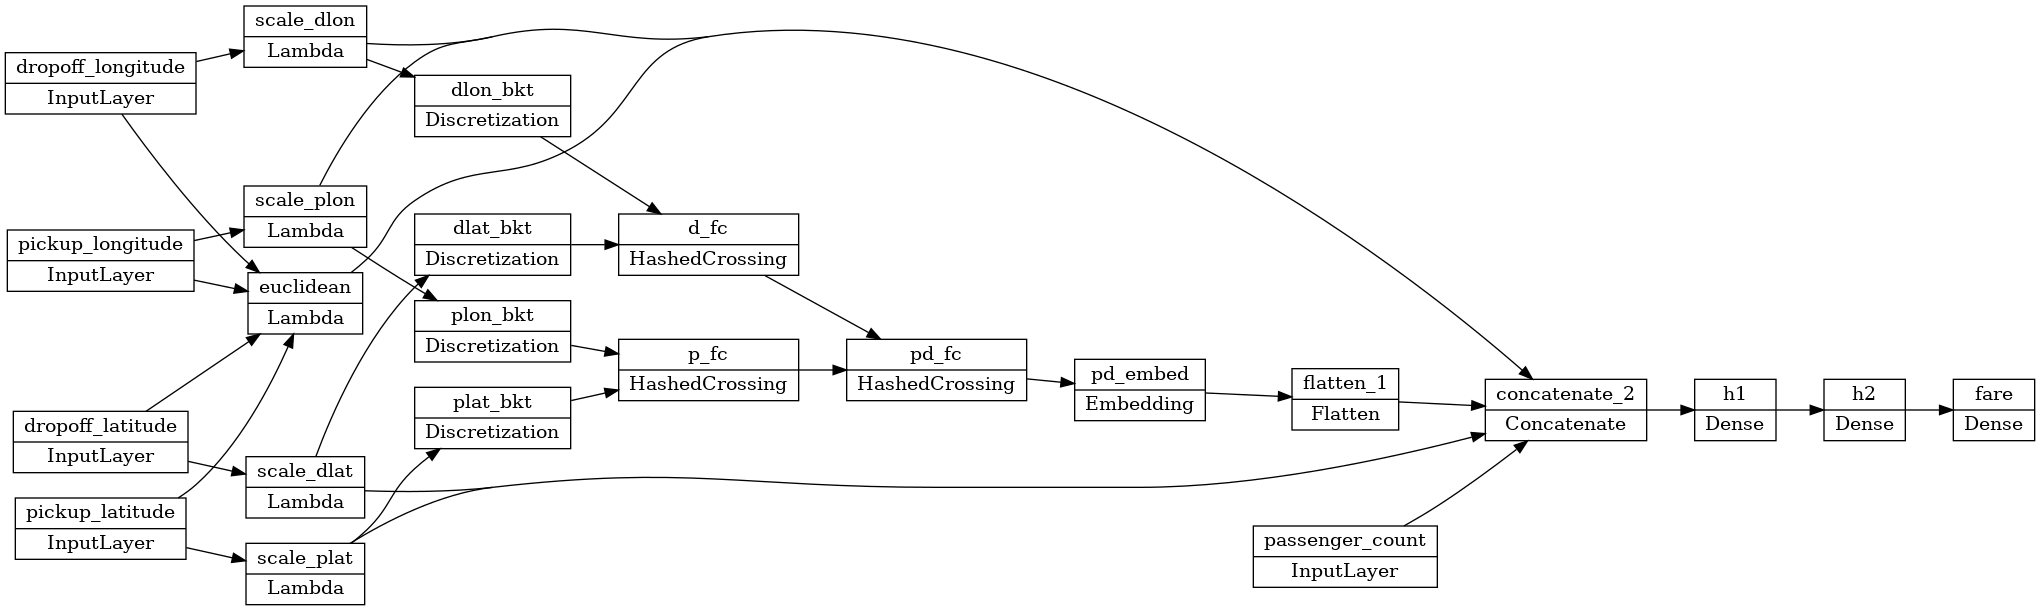

In [22]:
tf.keras.utils.plot_model(
    model, "dnn_model_engineered.png", show_shapes=False, rankdir="LR"
)

Now we can see this new model is applying various feature engineering techniques not only with predefined preprocessing layers but also with custom Lambda layers.<br>
All the preprocessed Tensors are combined in the `Concatenate` layer, and after that we can stack Dense layers.

Now let's train this new model and see how it works.

In [23]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 10
NUM_EVALS = 10
NUM_EVAL_EXAMPLES = 1000

In [25]:
trainds = load_dataset("../data/taxi-train*", TRAIN_BATCH_SIZE, "train")
evalds = load_dataset("../data/taxi-valid*", 1000, "eval").take(
    NUM_EVAL_EXAMPLES // 1000
)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
)  # TODO

Epoch 1/10
312/312 [==============================] - 3s 5ms/step - loss: 124.7989 - rmse: 10.4691 - val_loss: 126.9315 - val_rmse: 11.2664
Epoch 2/10
312/312 [==============================] - 1s 4ms/step - loss: 99.0111 - rmse: 9.2485 - val_loss: 111.1307 - val_rmse: 10.5419
Epoch 3/10
312/312 [==============================] - 1s 4ms/step - loss: 92.5329 - rmse: 8.8968 - val_loss: 92.7524 - val_rmse: 9.6308
Epoch 4/10
312/312 [==============================] - 1s 4ms/step - loss: 80.8956 - rmse: 8.4196 - val_loss: 93.1724 - val_rmse: 9.6526
Epoch 5/10
312/312 [==============================] - 1s 4ms/step - loss: 68.7420 - rmse: 7.7965 - val_loss: 85.8886 - val_rmse: 9.2676
Epoch 6/10
312/312 [==============================] - 1s 4ms/step - loss: 59.0573 - rmse: 7.2407 - val_loss: 67.9368 - val_rmse: 8.2424
Epoch 7/10
312/312 [==============================] - 1s 4ms/step - loss: 48.7276 - rmse: 6.3275 - val_loss: 48.7093 - val_rmse: 6.9792
Epoch 8/10
312/312 [======================

As before, let's visualize the DNN model layers. 

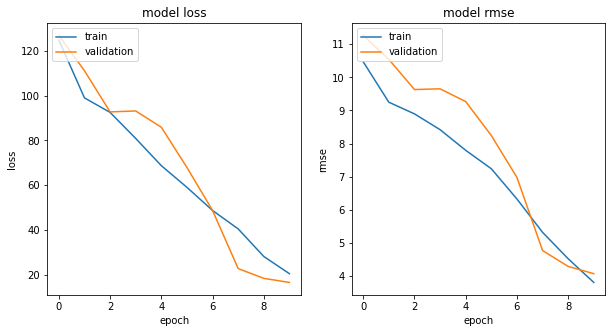

In [26]:
plot_curves(history, ["loss", "rmse"])

Let's a prediction with this new model with engineered features on the example we had above. 

In [27]:
model.predict(
    {
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

array([[7.9220004]], dtype=float32)

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.